In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats.mstats import mquantiles
from scipy import stats
import matplotlib.colors as mcolors

# Upload Data and Define Seasson Index 

(566, 8760, 14) (311, 8760, 14)


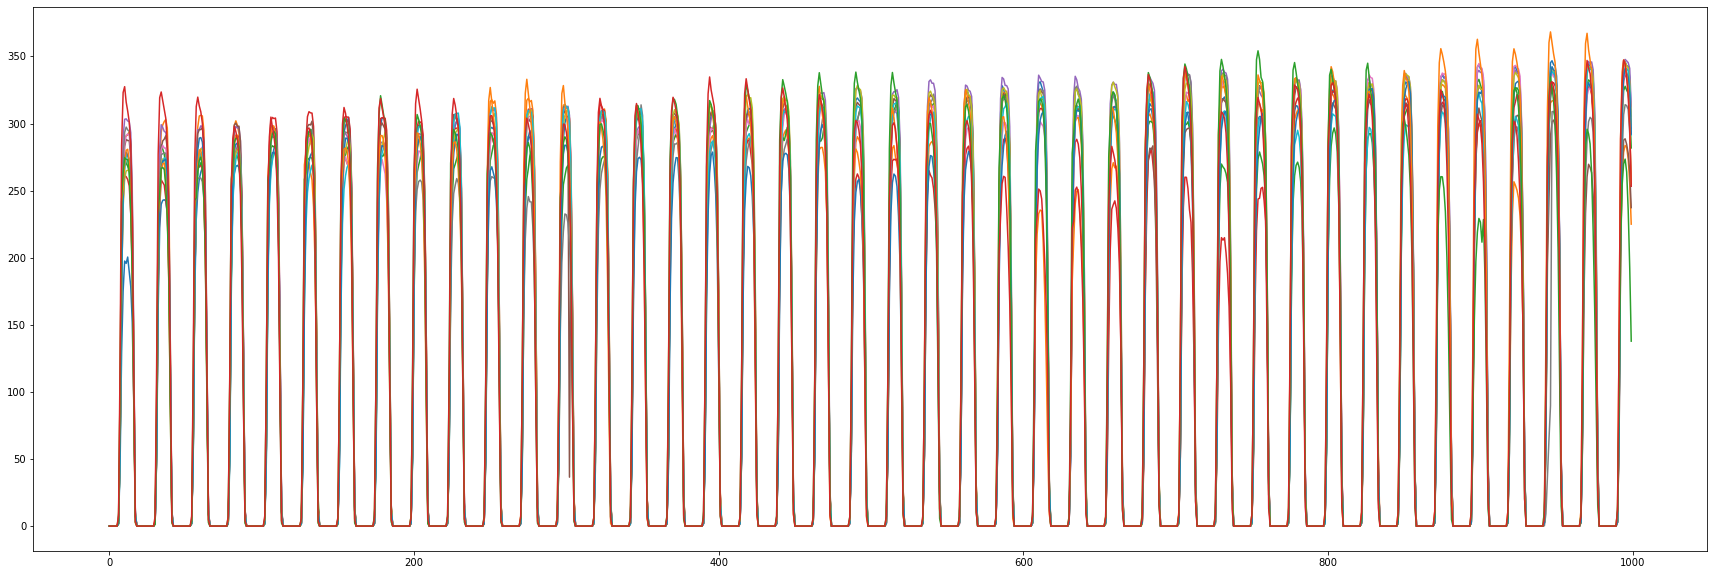

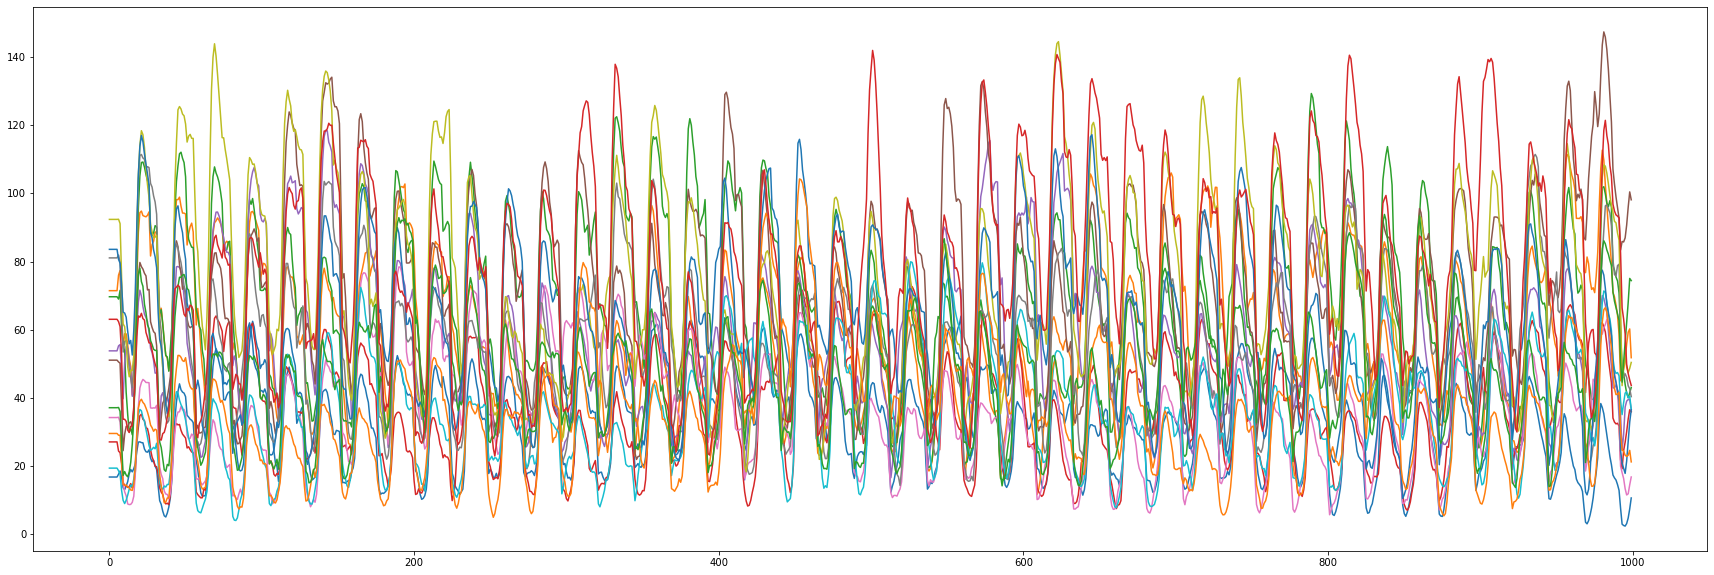

(566, 1) (311, 1)
90
92
91
92
(4, 365)


In [4]:
path_data   = r'/Users/Guille/Desktop/india_power/software/'
path_images = r'/Users/Guille/Desktop/india_power/images/'

with open(path_data + r'india_power_dataset.pkl', 'rb') as _file:
    load_, mapre_, capacity_           = pickle.load(_file)
    L_, time_                          = load_  
    s_Cap_, s_names_, w_Cap_, w_names_ = mapre_
    S_cf_, W_cf_                       = capacity_
    
# Remove leap years - bad processing in winter
S_cf_ = np.delete(S_cf_, [0, 4, 8, 12], axis = 2)
W_cf_ = np.delete(W_cf_, [0, 4, 8, 12], axis = 2)
print(S_cf_.shape, W_cf_.shape)

S_Cap_ = s_Cap_[:, np.newaxis]
W_Cap_ = w_Cap_[:, np.newaxis]

N_hours = 24
N_days  = 365
N_years = S_cf_.shape[-1]

plt.figure(figsize = (30, 10))
plt.plot(np.sum(S_cf_, axis = 0)[:1000])
plt.show()

plt.figure(figsize = (30, 10))
plt.plot(np.sum(W_cf_, axis = 0)[:1000])
plt.show()
print(S_Cap_.shape, W_Cap_.shape)

# Season indexing 
idx_days_ = np.arange(N_days, dtype = int)

# Spring Season indexing 
spring_begin = 79
spring_end   = 169
idx_spring_  = ((idx_days_ >= spring_begin) & (idx_days_ < spring_end))
print(idx_spring_.sum())

# Summer Season indexing 
summer_begin = 169
summer_end   = 261
idx_summer_  = ((idx_days_ >= summer_begin) & (idx_days_ < summer_end))
print(idx_summer_.sum())

# Fall Season indexing 
fall_begin = 261
fall_end   = 352
idx_fall_  = ((idx_days_ >= fall_begin) & (idx_days_ < fall_end))
print(idx_fall_.sum())

# Winter Season indexing 
winter_begin = 0
winter_end   = 79
winter_Begin = 352
winter_End   = 365
idx_winter_  = (((idx_days_ >= winter_begin) & (idx_days_ < winter_end)) | ((idx_days_ >= winter_Begin) & (idx_days_ <= winter_End)))
print(idx_winter_.sum())

season_idx_ = np.array([idx_winter_, idx_spring_, idx_summer_, idx_fall_])
print(season_idx_.shape)

# Total Energy Demand 

In [5]:
# hourly energy demand in India
N_states = L_.shape[-1]

l_ = np.sum(L_ , axis = 1)[:, np.newaxis]
# total energy demand of India
L = np.sum(l_, axis = 0) 

L_reshape_ = L_.reshape(N_days, N_hours, N_states) 
L_prime_   = np.sum(L_reshape_,axis = 2) 
L_days_    = np.sum( L_prime_, axis = 1)[:,np.newaxis]
print(L_days_.shape)

(365, 1)


# Average system scale 

In [6]:
def _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB):
    
    N_year_hours = S_cf_.shape[1]
    N_years      = S_cf_.shape[2]
    #1
    s_Cap_prime_ = np.repeat(s_Cap_[..., np.newaxis], N_year_hours, axis = 1)
    s_Cap_prime_ = np.repeat(s_Cap_prime_[..., np.newaxis], N_years, axis = 2)
    w_Cap_prime_ = np.repeat(w_Cap_[..., np.newaxis], N_year_hours, axis = 1)
    w_Cap_prime_ = np.repeat(w_Cap_prime_[..., np.newaxis], N_years, axis = 2)

    E_s_pot_year_ = s_Cap_prime_ * S_cf_
    E_w_pot_year_ = w_Cap_prime_ * W_cf_
    #2
    e_s_tot_years_ = np.sum(np.sum(E_s_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    e_w_tot_years_ = np.sum(np.sum(E_w_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    #3 
    beta_s_ = L/e_s_tot_years_
    beta_hat_s = np.mean(beta_s_) 
    
    beta_w_ = L/e_w_tot_years_
    beta_hat_w = np.mean(beta_w_) 
    
    #4 solar 
    a_s_avg = r_s * beta_hat_s * OB
    a_w_avg = r_w * beta_hat_w * OB

    return a_s_avg , a_w_avg, beta_s_, beta_w_


r_s = .5
r_w = 1. - r_s
OB  = 1.

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
print(a_hat_s, a_hat_w)

0.14295851840237575 0.2893819616312035


In [7]:
# To find the average daily generation 
def _hourly_gen_(cf_, Cap_, season_idx_, a_hat, y, N_days, N_years):
    E_scaled_a_ = a_hat * Cap_ * cf_[:, :, y] 
    E_hour_a_   = np.sum(E_scaled_a_, axis = 0) # (hours,years)
    E_prime_    = E_hour_a_.reshape(N_days, N_years)
    #solar 
    w_   = E_prime_[season_idx_[0], :] 
    spr_ = E_prime_[season_idx_[1], :] 
    smr_ = E_prime_[season_idx_[2], :] 
    f_   = E_prime_[season_idx_[3], :] 
    return w_, spr_, smr_, f_

def _daily_stats(Data_, q_ = [0.025, 0.2, 0.8, .975]):  
    # Median
    med_      = np.mean(Data_, axis = 0)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, q_, axis = 0)
    q_0_      = quantiles[0, :]
    q_25_     = quantiles[1, :]
    q_75_     = quantiles[2, :]
    q_100_    = quantiles[3, :]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

# seasonal solar 
S_gen_w_   = np.zeros((N_years, 92, N_hours))
S_gen_spr_ = np.zeros((N_years, 90, N_hours))
S_gen_smr_ = np.zeros((N_years, 92, N_hours))
S_gen_f_   = np.zeros((N_years, 91, N_hours))

for i in range(N_years):
    S_gen_w_[i], S_gen_spr_[i], S_gen_smr_[i], S_gen_f_[i] = _hourly_gen_(S_cf_, S_Cap_, season_idx_, a_hat_s, i, N_days, N_hours)
print(S_gen_w_.shape)

S_gen_w_   = S_gen_w_.reshape(S_gen_w_.shape[0]*S_gen_w_.shape[1], S_gen_w_.shape[2])
S_gen_spr_ = S_gen_spr_.reshape(S_gen_spr_.shape[0]*S_gen_spr_.shape[1], S_gen_spr_.shape[2])
S_gen_smr_ = S_gen_smr_.reshape(S_gen_smr_.shape[0]*S_gen_smr_.shape[1], S_gen_smr_.shape[2])
S_gen_f_   = S_gen_f_.reshape(S_gen_f_.shape[0]*S_gen_f_.shape[1], S_gen_f_.shape[2])

# seasonal wind 
W_gen_w_   = np.zeros((N_years, 92, N_hours))
W_gen_spr_ = np.zeros((N_years, 90, N_hours))
W_gen_smr_ = np.zeros((N_years, 92, N_hours))
W_gen_f_   = np.zeros((N_years, 91, N_hours))

for i in range(N_years):
    W_gen_w_[i], W_gen_spr_[i], W_gen_smr_[i], W_gen_f_[i] = _hourly_gen_(W_cf_, W_Cap_, season_idx_, a_hat_w, i, N_days, N_hours)
print(W_gen_w_.shape)

W_gen_w_   = W_gen_w_.reshape(W_gen_w_.shape[0]*W_gen_w_.shape[1], W_gen_w_.shape[2])
W_gen_spr_ = W_gen_spr_.reshape(W_gen_spr_.shape[0]*W_gen_spr_.shape[1], W_gen_spr_.shape[2])
W_gen_smr_ = W_gen_smr_.reshape(W_gen_smr_.shape[0]*W_gen_smr_.shape[1], W_gen_smr_.shape[2])
W_gen_f_   = W_gen_f_.reshape(W_gen_f_.shape[0]*W_gen_f_.shape[1], W_gen_f_.shape[2])

# seasonal Load 
L_w_   = L_prime_[idx_winter_, :]
L_spr_ = L_prime_[idx_spring_, :] 
L_smr_ = L_prime_[idx_summer_, :]
L_f_   = L_prime_[idx_fall_, :]

# Solar season stats
S_w_med_, S_w_q_0_ , S_w_q_25_, S_w_q_75_, S_w_q_100_           = _daily_stats(S_gen_w_) 
S_spr_med_, S_spr_q_0_ , S_spr_q_25_, S_spr_q_75_, S_spr_q_100_ = _daily_stats(S_gen_spr_)
S_smr_med_, S_smr_q_0_ , S_smr_q_25_, S_smr_q_75_, S_smr_q_100_ = _daily_stats(S_gen_smr_)
S_f_med_, S_f_q_0_ , S_f_q_25_, S_f_q_75_, S_f_q_100_           = _daily_stats(S_gen_f_)  

# Wind season stats
W_w_med_, W_w_q_0_ , W_w_q_25_, W_w_q_75_, W_w_q_100_           = _daily_stats(W_gen_w_) 
W_spr_med_, W_spr_q_0_ , W_spr_q_25_, W_spr_q_75_, W_spr_q_100_ = _daily_stats(W_gen_spr_)
W_smr_med_, W_smr_q_0_ , W_smr_q_25_, W_smr_q_75_, W_smr_q_100_ = _daily_stats(W_gen_smr_)
W_f_med_, W_f_q_0_ , W_f_q_25_, W_f_q_75_, W_f_q_100_           = _daily_stats(W_gen_f_)

# Load stats 
l_w_med_, l_w_q_0_, l_w_q_25_, l_w_q_75_, l_w_q_100_            = _daily_stats(L_w_)
l_spr_med_, l_spr_q_0_ , l_spr_q_25_, l_spr_q_75_, l_spr_q_100_ = _daily_stats(L_spr_)
l_smr_med_, l_smr_q_0_ , l_smr_q_25_, l_smr_q_75_, l_smr_q_100_ = _daily_stats(L_smr_)
l_f_med_, l_f_q_0_ , l_f_q_25_, l_f_q_75_, l_f_q_100_           = _daily_stats(L_f_)

(14, 92, 24)
(14, 92, 24)


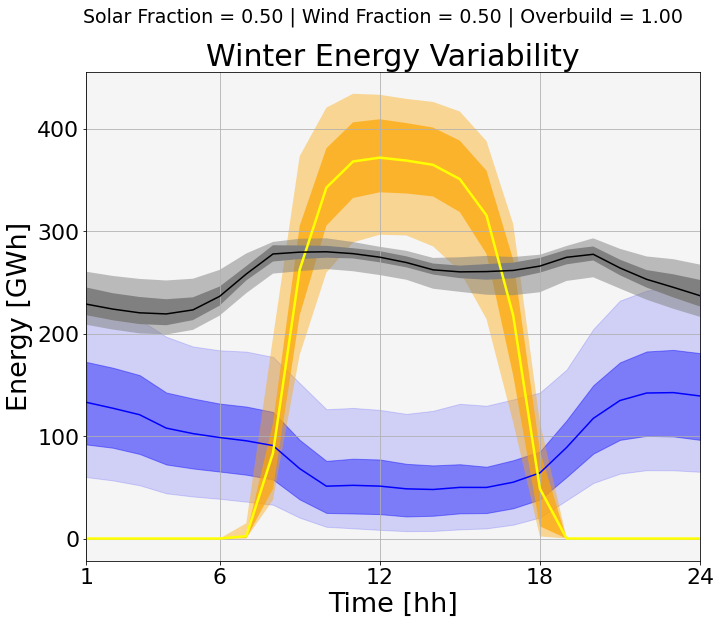

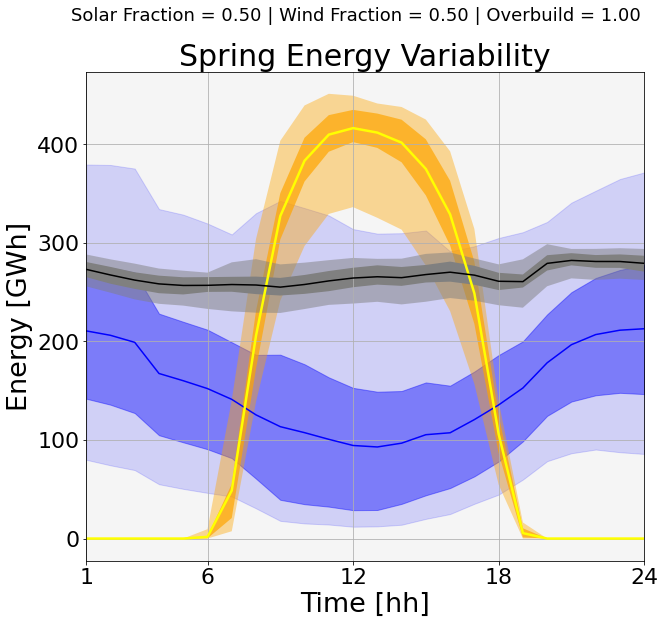

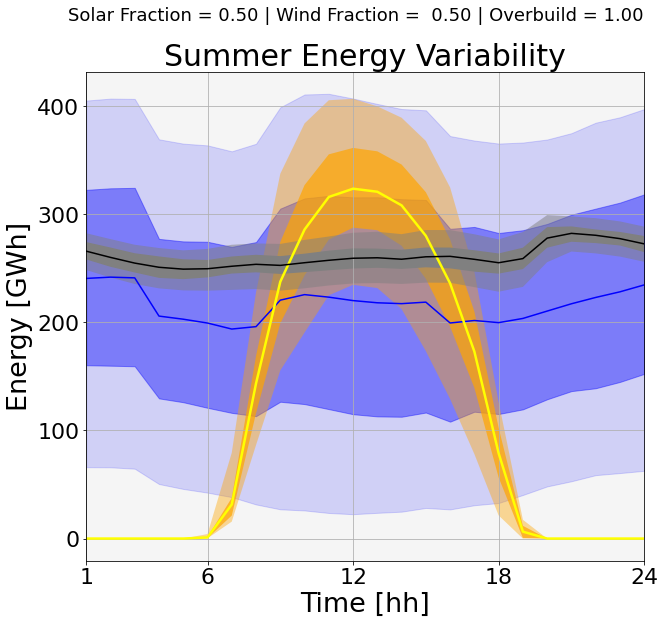

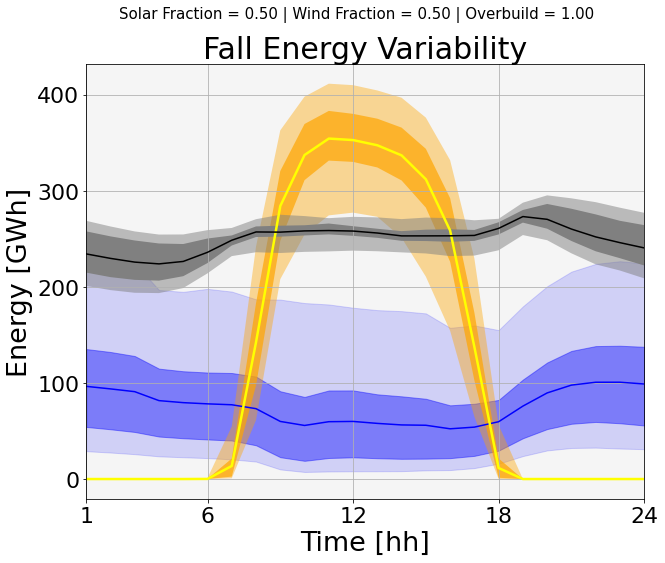

In [8]:
# winter
x_ = np.arange(0,24,1, dtype = int)
plt.figure(figsize = (11, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_w_med_/1000, 'b', label = 'Average Wind Generation',)
plt.fill_between(x_, W_w_q_0_[:, 0]/1000., W_w_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, W_w_q_25_[:, 0]/1000., W_w_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_w_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_w_q_0_[:, 0]/1000., S_w_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_w_q_25_[:, 0]/1000., S_w_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_w_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_w_q_0_[:, 0]/1000., l_w_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_w_q_25_[:, 0]/1000., l_w_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{20}-Q_{80}$')

plt.title('Winter Energy Variability', fontsize = 30, loc = 'center')
plt.suptitle('Solar Fraction = ' + "{:.2f}".format(r_s) + ' | Wind Fraction = '+  "{:.2f}".format(1-r_s) + ' | Overbuild = ' +  "{:.2f}".format(OB) , ha = 'center', va = 'top',fontsize=19.)

plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27)

plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 22)
plt.yticks(fontsize = 22.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 20.)
plt.savefig(path_images + 'Winter'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(1-r_s)+'_'+ "{:.1f}.png".format(OB), dpi='figure',bbox_inches='tight')

plt.grid()
plt.show()

# spring
plt.figure(figsize = (10, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_spr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_spr_q_0_[:, 0]/1000., W_spr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_spr_q_25_[:, 0]/1000., W_spr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_spr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_spr_q_0_[:, 0]/1000., S_spr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_spr_q_25_[:, 0]/1000., S_spr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_spr_q_0_[:, 0]/1000., l_spr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_spr_q_25_[:, 0]/1000., l_spr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Spring Energy Variability', fontsize = 30, loc = 'center')
plt.suptitle('Solar Fraction = ' + "{:.2f}".format(r_s) + ' | Wind Fraction = '+  "{:.2f}".format(r_w) + ' | Overbuild = ' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=18.)

plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27)
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 22.)
plt.yticks(fontsize= 22.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize= 22.)
plt.savefig(path_images + '_Spring'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB),dpi = 'figure',bbox_inches='tight')
plt.grid()
plt.show()

#summer
plt.figure(figsize = (10, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_smr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_smr_q_0_[:, 0]/1000., W_smr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_smr_q_25_[:, 0]/1000., W_smr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_smr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_smr_q_0_[:, 0]/1000., S_smr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_smr_q_25_[:, 0]/1000., S_smr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_smr_q_0_[:, 0]/1000., l_smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_smr_q_25_[:, 0]/1000., l_smr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Summer Energy Variability', fontsize = 30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction =  '+  "{:.2f}".format(1-r_s) + ' | Overbuild = ' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=18.)

plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27)
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 22.)
plt.yticks(fontsize = 22.)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize= 22.)
plt.savefig(path_images + '_Summer'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(1-r_s)+'_'+  "{:.1f}.png".format(OB), dpi='figure',bbox_inches='tight')
plt.grid()
plt.show()

# fall
plt.figure(figsize = (10, 8))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_f_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_f_q_0_[:, 0]/1000., W_f_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_f_q_25_[:, 0]/1000., W_f_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_f_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_f_q_0_[:, 0]/1000., S_f_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_f_q_25_[:, 0]/1000., S_f_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_f_q_0_[:, 0]/1000., l_f_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_f_q_25_[:, 0]/1000., l_f_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Fall Energy Variability', fontsize = 30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction = ' +  "{:.2f}".format(r_w) + ' | Overbuild = ' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=15.)
plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 22.)
plt.yticks(fontsize= 22.)

plt.savefig(path_images + '_Fall' + "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.2f}.png".format(OB), dpi = 'figure')

plt.grid()
plt.show()

# Annual Daily Variability

In [9]:
def _year_stats(Data_, q_ = [0., 0.25, 0.75, 1.]):  
    # Median
    med_      = np.mean(Data_, axis = 1)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, q_, axis = 1)
    q_0_      = quantiles[:,0]
    q_25_     = quantiles[:,1]
    q_75_     = quantiles[:,2]
    q_100_    = quantiles[:,3]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

# Yearly Wind gen Scaled 
E_w_scaled_a_  =  a_hat_w * W_Cap_[:,:,np.newaxis] * W_cf_
E_w_hour_a_    = np.sum(E_w_scaled_a_, axis= 0)
E_w_reshape_a_ = E_w_hour_a_.reshape(N_days, N_hours, N_years)
E_w_days_a_    = np.sum(E_w_reshape_a_,axis = 1)

# Yearly Solar gen Scaled 
E_s_scaled_a_  =  a_hat_s * S_Cap_[:,:,np.newaxis] * S_cf_
E_s_hour_a_    = np.sum(E_s_scaled_a_, axis= 0)
E_s_reshape_a_ = E_s_hour_a_.reshape(N_days, N_hours, N_years)
E_s_days_a_    = np.sum(E_s_reshape_a_,axis = 1)

# Annuals Solar Stats
S_med_a_, S_q_0_a_ , S_q_25_a_, S_q_75_a_, S_q_100_a_  = _year_stats(E_s_days_a_)
# Annuals Wind Stats
W_med_a_, W_q_0_a_ , W_q_25_a_, W_q_75_a_, W_q_100_a_  = _year_stats(E_w_days_a_)

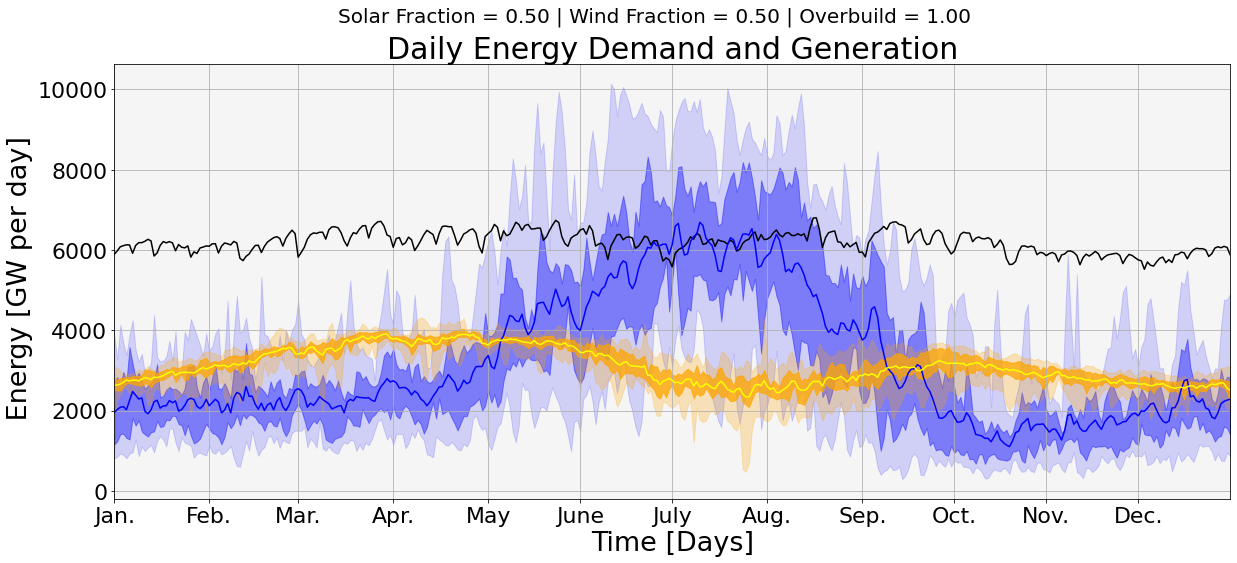

In [12]:
x_ =  np.arange(N_days, dtype = int)
months_day  = np.array([0, 31, 60, 91, 122, 152, 182, 213, 244, 274, 304, 334])
months_name = np.array(['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.','Sep.','Oct.','Nov.','Dec.'])

plt.figure(figsize = (20, 8))
plt.grid()
plt.gca().set_facecolor('whitesmoke')

plt.title('Daily Energy Demand and Generation',fontsize = 30,loc = 'center')
plt.suptitle('Solar Fraction = ' + "{:.2f}".format(r_s) + ' | Wind Fraction = ' +  "{:.2f}".format(r_w) + ' | Overbuild = ' + "{:.2f}".format(OB), ha = 'center', va = 'top', fontsize = 20.)
plt.xlabel('Time [Days]', fontsize = 27)
plt.ylabel(' Energy [GW per day]', fontsize = 27 )

plt.plot(x_, L_days_/1000, 'k', label = 'Daily Load Demand')

plt.plot(x_, W_med_a_/1000, 'b', label = 'Daily Wind Generation')
plt.fill_between(x_, W_q_0_a_[:, 0]/1000., W_q_100_a_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, W_q_25_a_[:, 0]/1000., W_q_75_a_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_med_a_/1000, 'yellow', label = 'Daily Solar Generation')
plt.fill_between(x_, S_q_0_a_[:, 0]/1000., S_q_100_a_[:, 0]/1000., alpha = .25,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_q_25_a_[:, 0]/1000., S_q_75_a_[:, 0]/1000., alpha = 0.75,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.xticks(months_day, months_name,fontsize = 22.)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 20.)
plt.yticks(fontsize = 22.)
plt.xlim([0, N_days - 1])

plt.savefig(path_images + 'Yearly' + "_{:.2f}".format(r_s) + '_' + "{:.2f}".format(r_w) + '_' + "{:.2f}.png".format(OB), dpi = 'figure')
plt.show()

# Energy System Simulation

In [13]:
def _battery_model(L_net, SOC, b_Cap): 
    
    def __discarge(L_net, SOC):
        D = abs(L_net)
        if D <= SOC: 
            SOC -= D
        else:
            D   = SOC 
            SOC = 0.
        return D, SOC 
    
    def __charge(L_net, SOC, b_Cap):
        C = L_net
        if (SOC + C) <= b_Cap:
            SOC += C 
        else:
            C   = b_Cap - SOC 
            SOC = b_Cap         
        return C, SOC
    # Shedding Event
    if L_net < 0.:
        D, SOC_star = __discarge(L_net, SOC) 
        return L_net + D, SOC_star
        
    # Balanced Event
    if L_net == 0.: 
        return L_net, SOC 
    
    # Curtailment Event
    if L_net > 0.:
        C, SOC_star = __charge(L_net, SOC, b_Cap)
        return L_net - C, SOC_star
    
def _eval_reliability(L_net_, L_):
    l_net_ = L_net_.flatten()
    # Hourly Reliability
    balanced  = np.sum(l_net_ == 0., axis = 0)
    curtailed = np.sum(l_net_ > 0. , axis = 0)
    shedded   = np.sum(l_net_ < 0. , axis = 0)

    R_time = (balanced + curtailed)/(shedded + curtailed + balanced)
    
    #Energy Balance Reliability
    idx_         = L_net_ >= 0.
    L_net_[idx_] = 0.
    R_energy     = np.mean((L_.flatten() + L_net_.flatten())/L_.flatten())

    return R_time, R_energy


def _simulate_scenario(S_cf_, W_cf_, s_Cap_, w_Cap_, L_, L, a_hat_s, a_hat_w, r_b, r_s, OB):

    # Scale Solar System
    E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
    E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

    # Scale Wind System
    E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis] * W_cf_
    E_w_hour_   = np.sum(E_w_scaled_, axis = 0)
    
    b_Cap = r_b * L / E_w_hour_.shape[0]
    
    L_net_ = np.zeros(E_w_hour_.shape)
    L_bat_ = np.zeros(E_w_hour_.shape)
    SOC_   = np.zeros(E_w_hour_.shape)

    SOC = 0.

    for i in range(E_w_hour_.shape[0]):
        for j in range(E_w_hour_.shape[1]):
            # Compute hourly net demand
            L_net_[i, j] = (E_s_hour_[i, j] + E_w_hour_[i, j]) - L_[i, j] 
            # Upate Baterry State Of Charge and Net Load
            if r_b > 0:
                L_net_[i, j], SOC_[i, j] = _battery_model(L_net_[i, j], SOC, b_Cap)
            else:
                pass
            SOC = SOC_[i, j]
            
    return L_net_

r_s_ = [0.,.25, .5, .75, 1.]
r_b_ = [0, 1, 2, 4, 8, 12]
OB_  = [1., 1.75]

L_  = np.repeat(l_, N_years, axis = 1)
print(L_.shape)

R_time_   = np.zeros((len(r_s_), len(r_b_), len(OB_)))
R_energy_ = np.zeros((len(r_s_), len(r_b_), len(OB_)))

for i in range((len(r_s_))) :
    for j in range(len(r_b_)) :
        for k in range(len(OB_)) :
            print(r_b_[j], r_s_[i], OB_[k])

            L_net_ = _simulate_scenario(S_cf_, W_cf_, s_Cap_, w_Cap_, L_, L, a_hat_s, a_hat_w, r_b_[j], r_s_[i], OB_[k])
            R_time , R_energy  = _eval_reliability(L_net_, L_)
            
            R_time_[i,j,k]   = R_time
            R_energy_[i,j,k] = R_energy
        
print(R_time_[:, :, 0].max(), R_time_[:, :, 1].max())
print(R_energy_[:, :, 0].max(), R_energy_[:, :, 1].max())

(8760, 14)
0 0.0 1.0
0 0.0 1.75
1 0.0 1.0
1 0.0 1.75
2 0.0 1.0
2 0.0 1.75
4 0.0 1.0
4 0.0 1.75
8 0.0 1.0
8 0.0 1.75
12 0.0 1.0
12 0.0 1.75
0 0.25 1.0
0 0.25 1.75
1 0.25 1.0
1 0.25 1.75
2 0.25 1.0
2 0.25 1.75
4 0.25 1.0
4 0.25 1.75
8 0.25 1.0
8 0.25 1.75
12 0.25 1.0
12 0.25 1.75
0 0.5 1.0
0 0.5 1.75
1 0.5 1.0
1 0.5 1.75
2 0.5 1.0
2 0.5 1.75
4 0.5 1.0
4 0.5 1.75
8 0.5 1.0
8 0.5 1.75
12 0.5 1.0
12 0.5 1.75
0 0.75 1.0
0 0.75 1.75
1 0.75 1.0
1 0.75 1.75
2 0.75 1.0
2 0.75 1.75
4 0.75 1.0
4 0.75 1.75
8 0.75 1.0
8 0.75 1.75
12 0.75 1.0
12 0.75 1.75
0 1.0 1.0
0 1.0 1.75
1 1.0 1.0
1 1.0 1.75
2 1.0 1.0
2 1.0 1.75
4 1.0 1.0
4 1.0 1.75
8 1.0 1.0
8 1.0 1.75
12 1.0 1.0
12 1.0 1.75
0.5844422700587084 0.5844422700587084
0.7897871137291076 0.7897871137291076


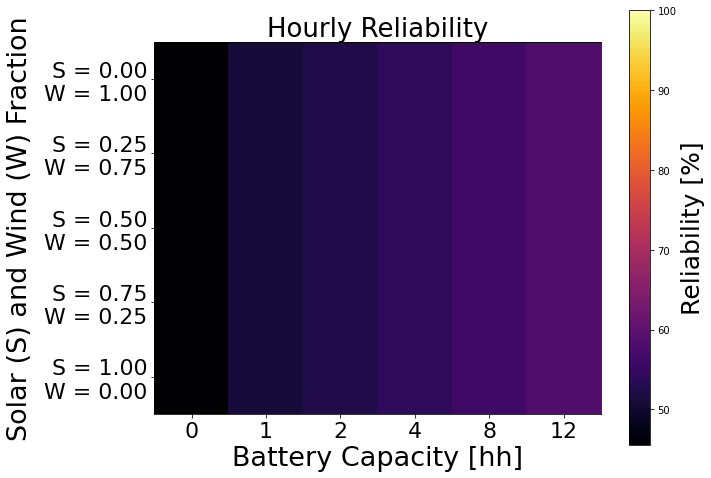

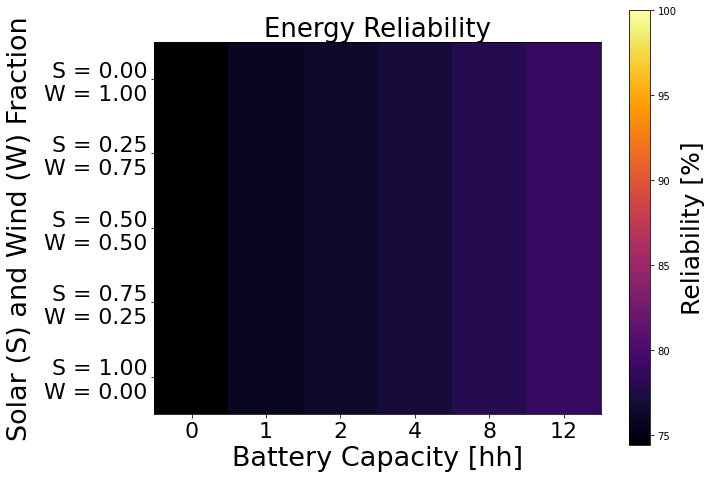

In [14]:
plt.figure(figsize = (10, 8))

plt.title('Hourly Reliability', fontsize = 26 )

plt.imshow(R_time_[:, :, 1] * 100., interpolation = 'none', vmax = 100, cmap = 'inferno')

plt.yticks([0, 1, 2, 3, 4],['S = ' + "{:.2f}".format(r_s_[0]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[0]),
                 'S = ' + "{:.2f}".format(r_s_[1]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S = ' + "{:.2f}".format(r_s_[4]) + '\n' +' W = '+  "{:.2f}".format(1-r_s_[4])], fontsize = 22)
plt.xticks([0, 1, 2, 3, 4, 5], r_b_, fontsize = 22)

cbar = plt.colorbar()
#cbar.set_ticklabels( cbar.get_ticks(), fontsize = 22)
cbar.set_label(label = 'Reliability [%]', fontsize = 25)

plt.ylabel('Solar (S) and Wind (W) Fraction', fontsize = 27) 
plt.xlabel('Battery Capacity [hh]',fontsize = 27)

plt.savefig(path_images + '_Hourly_Reliability.png', dpi = 'figure', bbox_inches = 'tight')


plt.show()

plt.figure(figsize = (10,8))
plt.title( 'Energy Reliability', fontsize = 26 )

plt.imshow(R_energy_[:,:,1] * 100, interpolation = 'none', vmax=100, cmap = 'inferno')

plt.yticks([0, 1, 2, 3, 4],['S = ' + "{:.2f}".format(r_s_[0]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[0]),
                 'S = ' + "{:.2f}".format(r_s_[1]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S = ' + "{:.2f}".format(r_s_[4]) + '\n' +' W = '+  "{:.2f}".format(1-r_s_[4])], fontsize = 22)

plt.xticks([0, 1, 2, 3, 4, 5], r_b_ , fontsize = 22)
cbar = plt.colorbar()
#cbar.set_ticklabels(cbar.get_ticks(), fontsize = 22)
cbar.set_label(label = 'Reliability [%]', fontsize = 25)

plt.ylabel('Solar (S) and Wind (W) Fraction', fontsize = 27) 
plt.xlabel('Battery Capacity [hh]',fontsize = 27)

plt.savefig(path_images + 'Energy_Reliability.png', dpi = 'figure' ,bbox_inches = 'tight')

plt.show()

# Ramp Rates

In [27]:
def _hourly_stats(data_, q_ = [.025, .2 , .8, .975]):  
    # Quantile Statistics
    m_ = np.mean(data_)
    q_ = stats.mstats.mquantiles(data_, q_)
    return m_, q_

dt  = 1

# Energy met reshaping 
E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
E_s_hour_   = np.sum(E_s_scaled_, axis = 0)

E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis] * W_cf_
E_w_hour_   = np.sum(E_w_scaled_, axis = 0)

L_net_ = ( E_s_hour_ + E_w_hour_) - l_

# Compute Ramp Rates
Rr_dt1_ = np.diff(L_net_, n = dt, axis = 0)/dt

# Ramp Rates to Percentage
Rr_dt1_frac_ = (Rr_dt1_ / l_[dt:])*100.

rr_dt1_ = Rr_dt1_frac_[:N_hours - dt, :]
Rr_dt1_ = Rr_dt1_frac_[N_hours - dt:, :]

rr_dt1_prime_ = rr_dt1_.flatten()[np.newaxis, :]
Rr_dt1_prime_ = np.reshape(Rr_dt1_, (N_days - 1, N_hours*N_years))

# Define Storage Vectors size of year days
m_pos_ = np.zeros((N_days, 1))
m_neg_ = np.zeros((N_days, 1))
Q_pos_ = np.zeros((N_days, 4))
Q_neg_ = np.zeros((N_days, 4))

# Compute stats for Janurary 1st positive
idx_ = rr_dt1_prime_[0, :] > 0.

# Compute Ramp Rates Variability
jan_1_med_pos, jan_1_q_pos_ = _hourly_stats(rr_dt1_prime_[0, idx_])
jan_1_med_neg, jan_1_q_neg_ = _hourly_stats(rr_dt1_prime_[0, ~idx_])

# Save Januaray 1st stats in Storage Vectors
m_pos_[0] = jan_1_med_pos
m_neg_[0] = jan_1_med_neg
Q_pos_[0, :] = jan_1_q_pos_
Q_neg_[0, :] = jan_1_q_neg_

# Ramp Rates for each year
for i in range(N_days - 1):
    idx_pos_ = Rr_dt1_prime_[i, :] > 0.
    
    # Compute Ramp Rates Variability
    med_pos, q_pos_ = _hourly_stats(Rr_dt1_prime_[i, idx_pos_])
    med_neg, q_neg_ = _hourly_stats(Rr_dt1_prime_[i, ~idx_pos_])

    m_pos_[i + 1] = med_pos
    m_neg_[i + 1] = med_neg
    Q_pos_[i + 1] = q_pos_
    Q_neg_[i + 1] = q_neg_

q_0_pos_      = Q_pos_[:, 0]
q_25_pos_     = Q_pos_[:, 1]
q_75_pos_     = Q_pos_[:, 2]
q_100_pos_    = Q_pos_[:, 3]    
q_0_neg_      = Q_neg_[:, 0]
q_25_neg_     = Q_neg_[:, 1]
q_75_neg_     = Q_neg_[:, 2]
q_100_neg_    = Q_neg_[:, 3]   
print(q_100_pos_.shape, m_neg_.shape, Q_pos_.shape, Q_neg_.shape)

0
0 189 147
1 192 144
2 196 140
3 188 148
4 194 142
5 186 150
6 180 156
7 185 151
8 189 147
9 176 160
10 184 152
11 189 147
12 193 143
13 185 151
14 179 157
15 185 151
16 187 149
17 188 148
18 182 154
19 185 151
20 186 150
21 196 140
22 183 153
23 182 154
24 188 148
25 173 163
26 179 157
27 177 159
28 184 152
29 180 156
30 174 162
31 182 154
32 172 164
33 184 152
34 169 167
35 184 152
36 178 158
37 181 155
38 183 153
39 176 160
40 181 155
41 184 152
42 180 156
43 175 161
44 181 155
45 171 165
46 182 154
47 173 163
48 171 165
49 166 170
50 162 174
51 164 172
52 166 170
53 167 169
54 173 163
55 171 165
56 182 154
57 171 165
58 159 177
59 148 188
60 150 186
61 155 181
62 152 184
63 164 172
64 150 186
65 164 172
66 153 183
67 146 190
68 147 189
69 144 192
70 150 186
71 149 187
72 153 183
73 152 184
74 160 176
75 176 160
76 153 183
77 164 172
78 168 168
79 163 173
80 168 168
81 153 183
82 159 177
83 154 182
84 155 181
85 161 175
86 166 170
87 165 171
88 158 178
89 160 176
90 163 173
91 149 

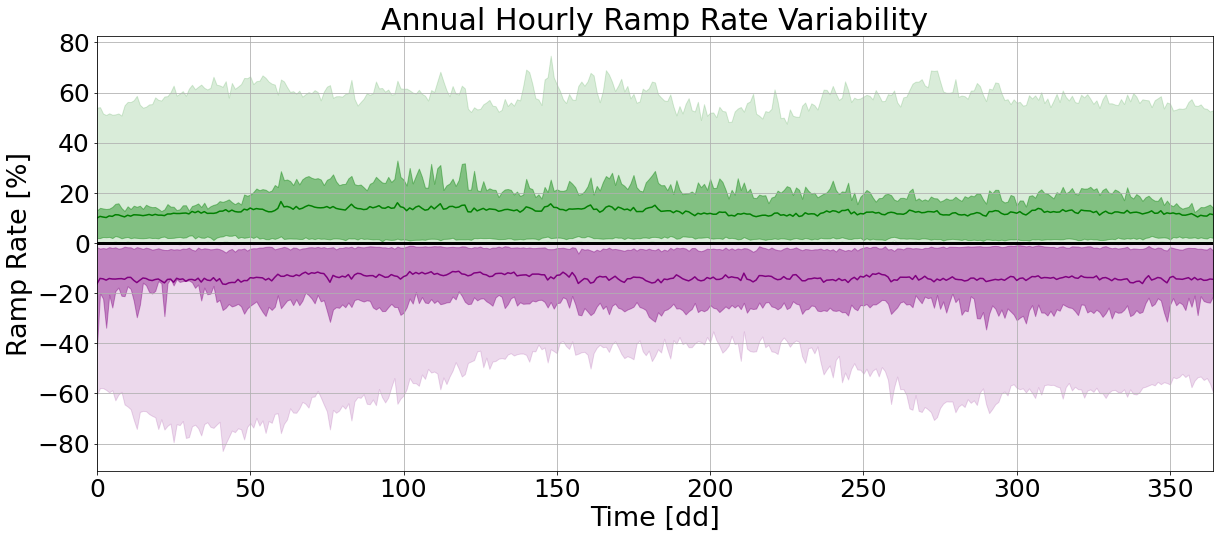

In [25]:
x_ =  np.arange(N_days, dtype = int)

plt.figure(figsize = (20, 8))

plt.plot(m_pos_, c = 'green', label = 'Daily Ramp-up Rates')
plt.fill_between(x_, q_100_pos_, q_0_pos_, alpha = 0.15, edgecolor = 'green', facecolor = 'green', label = '$Q_{20}-Q_{80}$')
plt.fill_between(x_, q_75_pos_, q_25_pos_, alpha = 0.4, edgecolor = 'green', facecolor = 'green', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(m_neg_, c = 'purple', label = 'Daily Ramp-down Rates')
plt.fill_between(x_, q_25_neg_, q_75_neg_, alpha = 0.4, edgecolor = 'purple', facecolor = 'purple', label = '$Q_{20}-Q_{80}$')
plt.fill_between(x_, q_100_neg_, q_0_neg_, alpha = 0.15, edgecolor = 'purple', facecolor = 'purple', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(np.repeat([0], N_days),'k', linewidth = 3)

plt.title('Annual Hourly Ramp Rate Variability', fontsize = 30)
#plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=17.)

plt.xlabel('Time [dd]', fontsize = 27)
plt.ylabel('Ramp Rate [%]', fontsize = 27)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlim([0, N_days - 1])

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 22.)
plt.savefig(path_images + '_Ramp_Rates' + '_' + "{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w) + '_' + "{:.1f}.png".format(OB), dpi = 'figure')

plt.grid()
plt.show()

# Daily Energy Balance 

In [65]:
def _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w, N_years, N_days, N_hours):

    E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
    E_s_hour_   = np.sum(E_s_scaled_, axis = 0)

    E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis] * W_cf_
    E_w_hour_   = np.sum(E_w_scaled_, axis = 0)
    E_net_      = (E_s_hour_ + E_w_hour_) - l_
    
    E_net_prime_ = np.reshape(E_net_, (N_days, N_hours, N_years))
    E_net_daily_ = np.sum(E_net_prime_, axis = 1)
    L_prime_     = np.reshape(l_, (N_days, N_hours, 1))
    L_net_daily_ = np.sum(L_prime_, axis = 1)
    print(E_net_daily_.shape)
    print(L_net_daily_.shape)

    R_ = 100 * (E_net_daily_ / L_net_daily_)
    
    return R_

N_per_ =  _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w, N_years, N_days, N_hours)

(365, 14)
(365, 1)


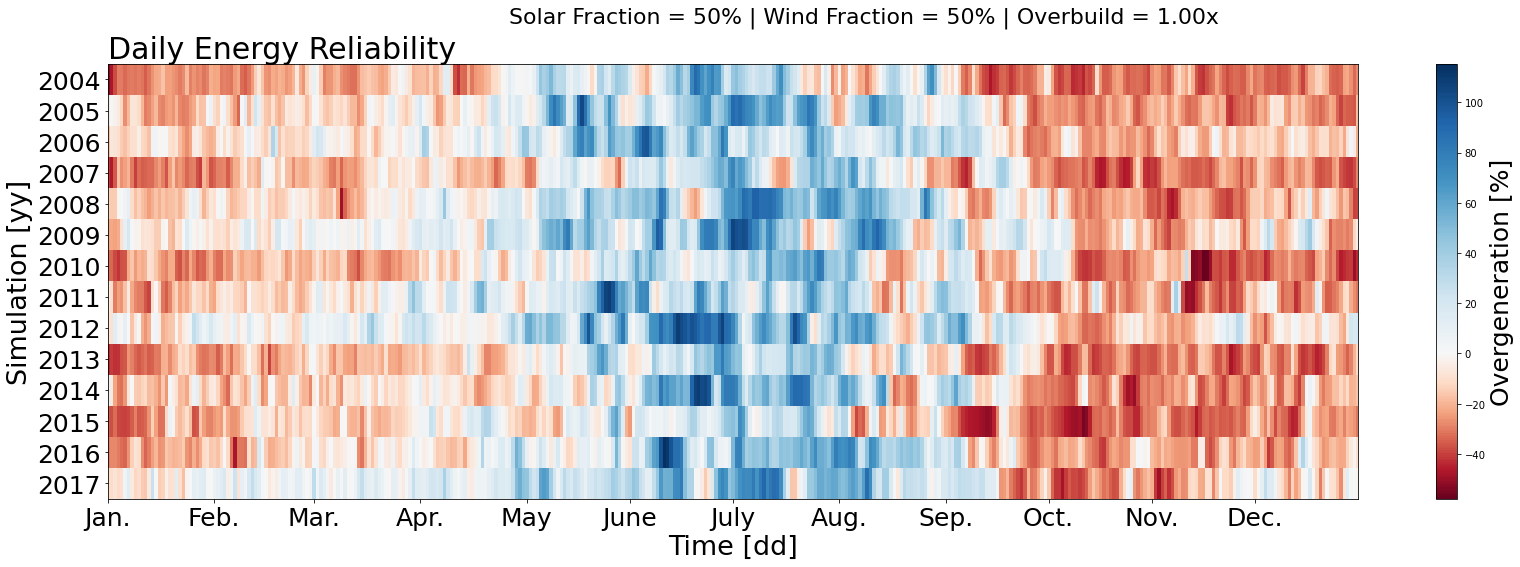

In [66]:
plt.figure(figsize = (28, 8))
plt.title('Daily Energy Reliability',fontsize = 30, loc = 'left')
plt.suptitle(r'Solar Fraction = {}%'.format(int(r_s*100)) + ' | Wind Fraction = {}%'.format(int(r_w*100)) + ' | Overbuild = {:.2f}x'.format(OB), ha = 'center', va = 'top',fontsize=22.)

plt.xlabel('Time [dd]', fontsize = 27)
plt.ylabel('Simulation [yy]', fontsize = 27 )

norm = mcolors.TwoSlopeNorm(vmin = N_per_.min(), vcenter = 0., vmax = N_per_.max())
cax = plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', norm = norm, cmap = 'RdBu')

plt.xticks(year_, months_, fontsize = 25)
plt.yticks(np.arange(0, N_years, 1), np.arange(2004, 2018, 1), fontsize = 25)
plt.xlim([0, N_days - 1])

cbar = plt.colorbar(cax)
#cbar.ax.set_yticklabels(['-100', '-50', '0', '167.5', '325'], fontsize = 22)  # vertically oriented colorbar

cbar.set_label(label = 'Overgeneration [%]', fontsize = 25)
plt.savefig(path_images + 'Best_Resiliance' + '_' + "{:.2f}".format(r_s) + '_' + "{:.2f}".format(r_w) + '_' + "{:.1f}.png".format(OB), dpi = 'figure')
plt.show()